In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F
import numpy as np
import math
import matplotlib.pyplot as plt

import os
import pathlib
from tqdm import tqdm
import gc

from visualisation import visualize_samples, visualize_results
from evaluation import psnr, mse, ssim
from models import SRCNN, ESPCN, SRGenerator, SRDiscriminator

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [18]:
class SuperResolutionDataset(Dataset):
    def __init__(self, hr_dir, lr_dir):
        self.hr_dir = hr_dir
        self.lr_dir = lr_dir
        # Get file names without extension
        self.file_names = [f.stem for f in self.hr_dir.glob("*.npy")]
        self.hr_files = sorted(self.hr_dir.glob("HR_*.npy"))
        self.lr_files = sorted(self.lr_dir.glob("LR_*.npy"))

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        hr_file_name = self.hr_files[idx]
        lr_file_name = self.lr_files[idx]

        hr_path = f"{hr_file_name}"
        lr_path = f"{lr_file_name}"

        # Load .npy files
        hr_image = np.load(hr_path).astype(np.float32)
        lr_image = np.load(lr_path).astype(np.float32)

        # Convert to PyTorch tensors
        hr_image = torch.from_numpy(hr_image)  # Assuming images are (H, W, C)
        lr_image = torch.from_numpy(lr_image)

        return lr_image, hr_image

In [19]:
hr_dir = pathlib.Path("Dataset 3B") / "HR"
lr_dir = pathlib.Path("Dataset 3B") / "LR"

hr_dir, lr_dir

(PosixPath('Dataset 3B/HR'), PosixPath('Dataset 3B/LR'))

In [20]:
# Create dataset
dataset = SuperResolutionDataset(hr_dir, lr_dir)

# Train-test split (90-10)
train_size = 0.9  # 90%
test_size = 0.1    # 10%
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Example usage
for lr, hr in train_loader:
    print(f"LR shape: {lr.shape}, HR shape: {hr.shape}")
    break

LR shape: torch.Size([16, 1, 64, 64]), HR shape: torch.Size([16, 1, 128, 128])


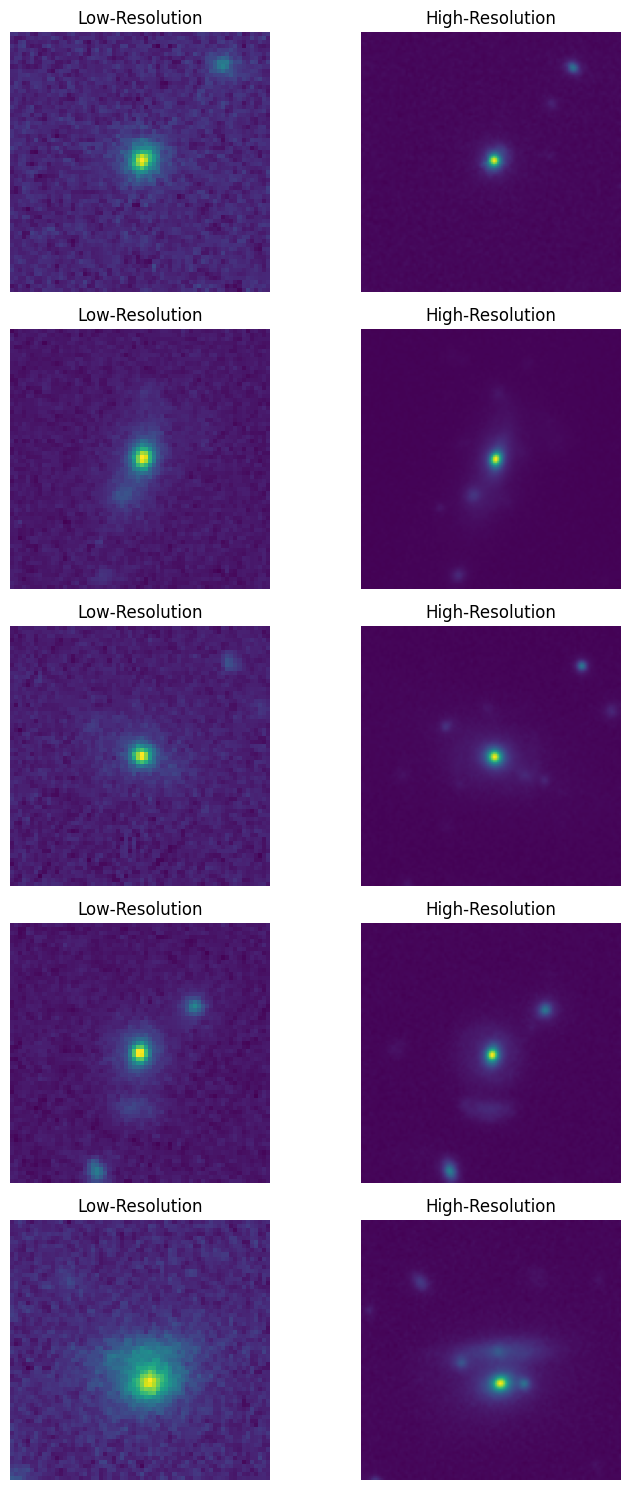

In [21]:
visualize_samples(train_loader, num_samples=5)

# Fine-tuning

## SRCNN Models

### SRCNN Model 1

In [ ]:
model = SRCNN(2, 64, [32], 5, [1], 3)
model = model.to(device)
model_load_path = "saved_models/best_sr_model.pth" 
model.load_state_dict(torch.load(model_load_path))

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 50
patience = 5  # Stop training if no improvement for 5 consecutive epochs
best_val_loss = float('inf')
epochs_no_improve = 0
model_save_path = "saved_models/best_sr_model_ft_1.pth"  # Path to save the best model

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    for lr_imgs, hr_imgs in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        lr_imgs, hr_imgs = lr_imgs.to(device), hr_imgs.to(device)

        sr_imgs = model(lr_imgs)

        loss = criterion(sr_imgs, hr_imgs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)

    # Validation step
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for lr_imgs, hr_imgs in test_loader:
            lr_imgs, hr_imgs = lr_imgs.to(device), hr_imgs.to(device)
            sr_imgs = model(lr_imgs)
            val_loss += criterion(sr_imgs, hr_imgs).item()

    avg_val_loss = val_loss / len(test_loader)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss}, Val Loss: {avg_val_loss}")

    # Early Stopping & Model Saving
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), model_save_path)  # Save best model
        print(f"✔ Model saved with Val Loss: {best_val_loss}")
    else:
        epochs_no_improve += 1
        print(f"❌ No improvement for {epochs_no_improve}/{patience} epochs.")

    if epochs_no_improve >= patience:
        print("⏹ Early stopping triggered!")
        break  # Stop training if no improvement for 'patience' epochs

print("✅ Training complete!")
print(f"📁 Best model saved at: {model_save_path}")

Epoch 1/50:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 1/50: 100%|██████████| 17/17 [00:00<00:00, 38.53it/s]


Epoch [1/50] - Train Loss: 0.0055628185680903055, Val Loss: 0.0023040385567583144
✔ Model saved with Val Loss: 0.0023040385567583144


Epoch 2/50: 100%|██████████| 17/17 [00:00<00:00, 39.26it/s]


Epoch [2/50] - Train Loss: 0.002299709488665137, Val Loss: 0.00125626745284535
✔ Model saved with Val Loss: 0.00125626745284535


Epoch 3/50: 100%|██████████| 17/17 [00:00<00:00, 38.95it/s]


Epoch [3/50] - Train Loss: 0.001989500648479032, Val Loss: 0.0011028953886125237
✔ Model saved with Val Loss: 0.0011028953886125237


Epoch 4/50: 100%|██████████| 17/17 [00:00<00:00, 41.31it/s]


Epoch [4/50] - Train Loss: 0.0017909775351119392, Val Loss: 0.001035930181387812
✔ Model saved with Val Loss: 0.001035930181387812


Epoch 5/50: 100%|██████████| 17/17 [00:00<00:00, 40.39it/s]


Epoch [5/50] - Train Loss: 0.0017049901310683174, Val Loss: 0.00102689114282839
✔ Model saved with Val Loss: 0.00102689114282839


Epoch 6/50: 100%|██████████| 17/17 [00:00<00:00, 40.60it/s]


Epoch [6/50] - Train Loss: 0.001668391187730081, Val Loss: 0.0009618503972887993
✔ Model saved with Val Loss: 0.0009618503972887993


Epoch 7/50: 100%|██████████| 17/17 [00:00<00:00, 41.29it/s]


Epoch [7/50] - Train Loss: 0.0016407253296004936, Val Loss: 0.0009573056304361671
✔ Model saved with Val Loss: 0.0009573056304361671


Epoch 8/50: 100%|██████████| 17/17 [00:00<00:00, 41.26it/s]


Epoch [8/50] - Train Loss: 0.0016274463097729226, Val Loss: 0.000922576553421095
✔ Model saved with Val Loss: 0.000922576553421095


Epoch 9/50: 100%|██████████| 17/17 [00:00<00:00, 41.24it/s]


Epoch [9/50] - Train Loss: 0.0016186923500807846, Val Loss: 0.00093274493701756
❌ No improvement for 1/5 epochs.


Epoch 10/50: 100%|██████████| 17/17 [00:00<00:00, 41.13it/s]


Epoch [10/50] - Train Loss: 0.0016031120116274584, Val Loss: 0.0009113468695431948
✔ Model saved with Val Loss: 0.0009113468695431948


Epoch 11/50: 100%|██████████| 17/17 [00:00<00:00, 41.34it/s]


Epoch [11/50] - Train Loss: 0.0015832940595881903, Val Loss: 0.000902813277207315
✔ Model saved with Val Loss: 0.000902813277207315


Epoch 12/50: 100%|██████████| 17/17 [00:00<00:00, 41.34it/s]


Epoch [12/50] - Train Loss: 0.0015715265934191207, Val Loss: 0.0008662867767270654
✔ Model saved with Val Loss: 0.0008662867767270654


Epoch 13/50: 100%|██████████| 17/17 [00:00<00:00, 41.35it/s]


Epoch [13/50] - Train Loss: 0.0015673316015368875, Val Loss: 0.0008482538105454296
✔ Model saved with Val Loss: 0.0008482538105454296


Epoch 14/50: 100%|██████████| 17/17 [00:00<00:00, 40.69it/s]


Epoch [14/50] - Train Loss: 0.0015471971093896119, Val Loss: 0.0008447935688309371
✔ Model saved with Val Loss: 0.0008447935688309371


Epoch 15/50: 100%|██████████| 17/17 [00:00<00:00, 39.25it/s]


Epoch [15/50] - Train Loss: 0.0015507322900435504, Val Loss: 0.0008022591937333345
✔ Model saved with Val Loss: 0.0008022591937333345


Epoch 16/50: 100%|██████████| 17/17 [00:00<00:00, 40.98it/s]


Epoch [16/50] - Train Loss: 0.0015364908407825757, Val Loss: 0.0007972359890118241
✔ Model saved with Val Loss: 0.0007972359890118241


Epoch 17/50: 100%|██████████| 17/17 [00:00<00:00, 41.10it/s]


Epoch [17/50] - Train Loss: 0.001508370367125334, Val Loss: 0.0007530513103120029
✔ Model saved with Val Loss: 0.0007530513103120029


Epoch 18/50: 100%|██████████| 17/17 [00:00<00:00, 39.78it/s]


Epoch [18/50] - Train Loss: 0.0014885571059387397, Val Loss: 0.0007678044785279781
❌ No improvement for 1/5 epochs.


Epoch 19/50: 100%|██████████| 17/17 [00:00<00:00, 39.29it/s]


Epoch [19/50] - Train Loss: 0.001490829824059106, Val Loss: 0.0007453265716321766
✔ Model saved with Val Loss: 0.0007453265716321766


Epoch 20/50: 100%|██████████| 17/17 [00:00<00:00, 38.73it/s]


Epoch [20/50] - Train Loss: 0.0014837472596863175, Val Loss: 0.0007361851312452927
✔ Model saved with Val Loss: 0.0007361851312452927


Epoch 21/50: 100%|██████████| 17/17 [00:00<00:00, 40.62it/s]


Epoch [21/50] - Train Loss: 0.0014787026020177804, Val Loss: 0.0007091546431183815
✔ Model saved with Val Loss: 0.0007091546431183815


Epoch 22/50: 100%|██████████| 17/17 [00:00<00:00, 41.15it/s]


Epoch [22/50] - Train Loss: 0.0014737861176185748, Val Loss: 0.0007255784294102341
❌ No improvement for 1/5 epochs.


Epoch 23/50: 100%|██████████| 17/17 [00:00<00:00, 41.28it/s]


Epoch [23/50] - Train Loss: 0.0014661431538543718, Val Loss: 0.0006976822769502178
✔ Model saved with Val Loss: 0.0006976822769502178


Epoch 24/50: 100%|██████████| 17/17 [00:00<00:00, 39.00it/s]


Epoch [24/50] - Train Loss: 0.0014667363857905217, Val Loss: 0.0007285354658961296
❌ No improvement for 1/5 epochs.


Epoch 25/50: 100%|██████████| 17/17 [00:00<00:00, 40.34it/s]


Epoch [25/50] - Train Loss: 0.001466965747942381, Val Loss: 0.0006764915597159415
✔ Model saved with Val Loss: 0.0006764915597159415


Epoch 26/50: 100%|██████████| 17/17 [00:00<00:00, 40.88it/s]


Epoch [26/50] - Train Loss: 0.0014608831535203055, Val Loss: 0.0006941851897863671
❌ No improvement for 1/5 epochs.


Epoch 27/50: 100%|██████████| 17/17 [00:00<00:00, 40.62it/s]


Epoch [27/50] - Train Loss: 0.001454749721554382, Val Loss: 0.0006888624193379655
❌ No improvement for 2/5 epochs.


Epoch 28/50: 100%|██████████| 17/17 [00:00<00:00, 40.74it/s]


Epoch [28/50] - Train Loss: 0.0014630302800523007, Val Loss: 0.0006803656870033592
❌ No improvement for 3/5 epochs.


Epoch 29/50: 100%|██████████| 17/17 [00:00<00:00, 38.58it/s]


Epoch [29/50] - Train Loss: 0.0014706029049942598, Val Loss: 0.0006699744990328327
✔ Model saved with Val Loss: 0.0006699744990328327


Epoch 30/50: 100%|██████████| 17/17 [00:00<00:00, 40.52it/s]


Epoch [30/50] - Train Loss: 0.0014346332070143783, Val Loss: 0.0007002669299254194
❌ No improvement for 1/5 epochs.


Epoch 31/50: 100%|██████████| 17/17 [00:00<00:00, 40.08it/s]


Epoch [31/50] - Train Loss: 0.0014655537721837925, Val Loss: 0.0006700748926959932
❌ No improvement for 2/5 epochs.


Epoch 32/50: 100%|██████████| 17/17 [00:00<00:00, 41.14it/s]


Epoch [32/50] - Train Loss: 0.0014411288686781464, Val Loss: 0.00066491833422333
✔ Model saved with Val Loss: 0.00066491833422333


Epoch 33/50: 100%|██████████| 17/17 [00:00<00:00, 38.08it/s]


Epoch [33/50] - Train Loss: 0.0014566499637165928, Val Loss: 0.0006769091123715043
❌ No improvement for 1/5 epochs.


Epoch 34/50: 100%|██████████| 17/17 [00:00<00:00, 41.15it/s]


Epoch [34/50] - Train Loss: 0.0014381719486075727, Val Loss: 0.0006718850490869954
❌ No improvement for 2/5 epochs.


Epoch 35/50: 100%|██████████| 17/17 [00:00<00:00, 40.79it/s]


Epoch [35/50] - Train Loss: 0.0014834191739175689, Val Loss: 0.000653594484901987
✔ Model saved with Val Loss: 0.000653594484901987


Epoch 36/50: 100%|██████████| 17/17 [00:00<00:00, 40.97it/s]


Epoch [36/50] - Train Loss: 0.0014543558046331301, Val Loss: 0.0006605983071494848
❌ No improvement for 1/5 epochs.


Epoch 37/50: 100%|██████████| 17/17 [00:00<00:00, 41.41it/s]


Epoch [37/50] - Train Loss: 0.0014419929374365464, Val Loss: 0.0006627806578762829
❌ No improvement for 2/5 epochs.


Epoch 38/50: 100%|██████████| 17/17 [00:00<00:00, 39.09it/s]


Epoch [38/50] - Train Loss: 0.0014501157908371704, Val Loss: 0.0006565761723322794
❌ No improvement for 3/5 epochs.


Epoch 39/50: 100%|██████████| 17/17 [00:00<00:00, 38.06it/s]


Epoch [39/50] - Train Loss: 0.001423479722100584, Val Loss: 0.000662977879983373
❌ No improvement for 4/5 epochs.


Epoch 40/50: 100%|██████████| 17/17 [00:00<00:00, 39.77it/s]


Epoch [40/50] - Train Loss: 0.0014292242464280741, Val Loss: 0.0006560357433045283
❌ No improvement for 5/5 epochs.
⏹ Early stopping triggered!
✅ Training complete!
📁 Best model saved at: saved_models/best_sr_model_ft_1.pth


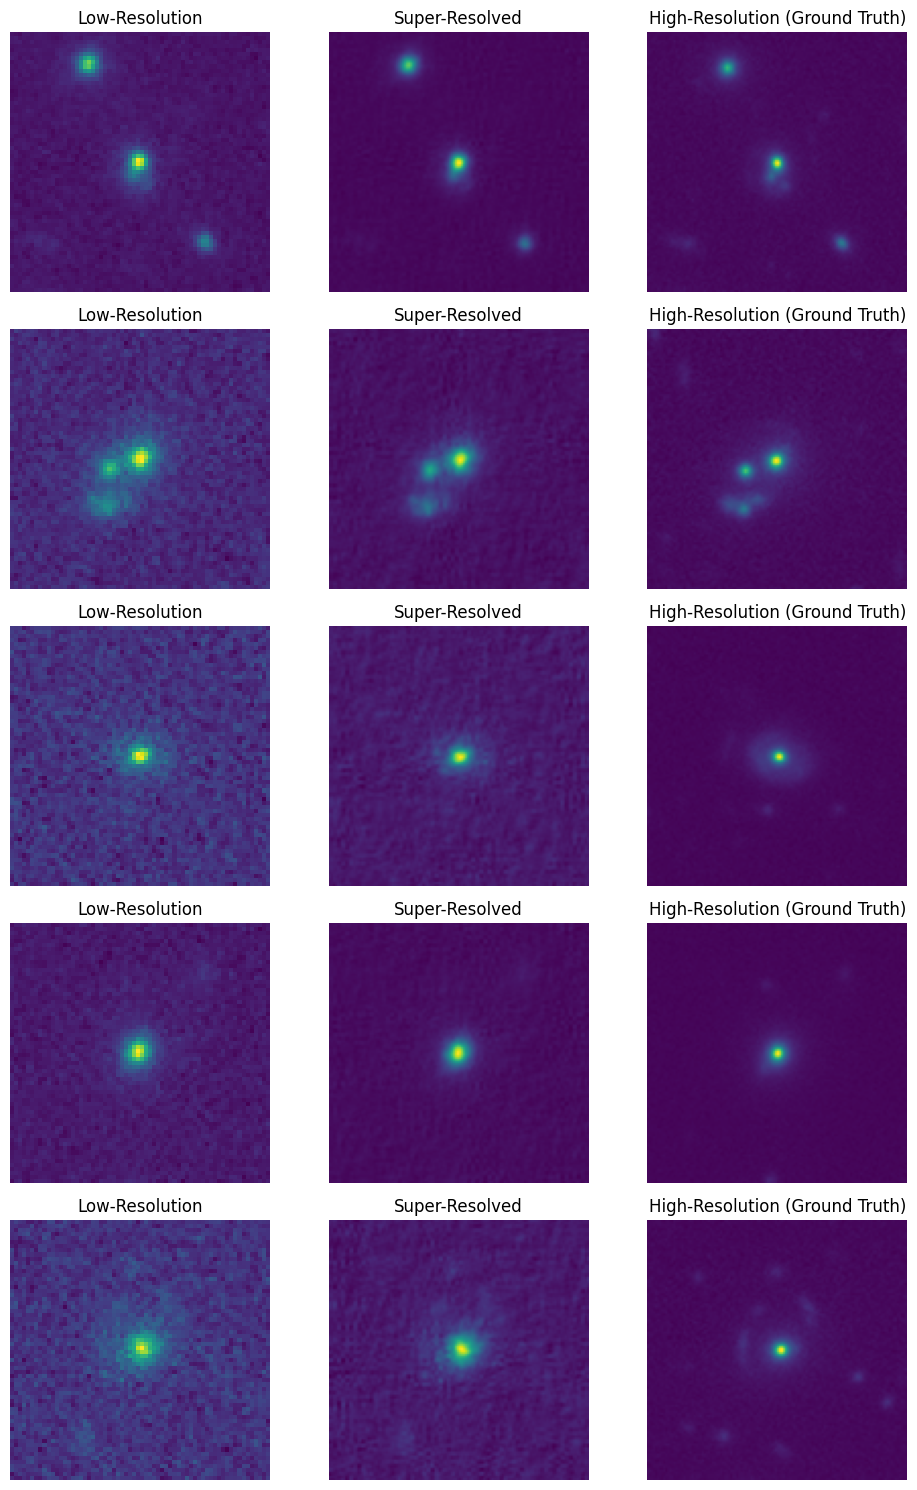

Final Evaluation - MSE: 0.0006691875916051989, PSNR: 33.130778234567074, SSIM: 0.8180066347122192


In [25]:
model = SRCNN(2, 64, [32], 5, [1], 3)
model = model.to(device)
model_save_path = "saved_models/best_sr_model_ft_1.pth"
model.load_state_dict(torch.load(model_save_path))
visualize_results(model, test_loader, num_samples=5, device=device)

model.eval()

# Evaluation loop
total_psnr, total_ssim, total_mse = 0.0, 0.0, 0.0
num_images = 0

with torch.no_grad():
    for lr_imgs, hr_imgs in test_loader:
        lr_imgs, hr_imgs = lr_imgs.to(device), hr_imgs.to(device)
        sr_imgs = model(lr_imgs)  # Generate SR images

        # Compute MSE, PSNR & SSIM for each image
        for i in range(lr_imgs.shape[0]):
            total_mse += mse(sr_imgs[i], hr_imgs[i])
            total_psnr += psnr(sr_imgs[i], hr_imgs[i], 255)
            total_ssim += ssim(sr_imgs[i].unsqueeze(0), hr_imgs[i].unsqueeze(0))
            num_images += 1

# Compute final average MSE, PSNR & SSIM
avg_mse = total_mse / num_images
avg_psnr = total_psnr / num_images
avg_ssim = total_ssim / num_images

print(f"Final Evaluation - MSE: {avg_mse}, PSNR: {avg_psnr}, SSIM: {avg_ssim}")

### SRCNN Model 2

In [ ]:
model = SRCNN(2, 32, [16], 9, [3], 5)
model = model.to(device)
model_load_path = "saved_models/best_sr_model_2.pth" 
model.load_state_dict(torch.load(model_load_path))

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 50
patience = 5  # Stop training if no improvement for 5 consecutive epochs
best_val_loss = float('inf')
epochs_no_improve = 0
model_save_path = "saved_models/best_sr_model_ft_2.pth"  # Path to save the best model

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    for lr_imgs, hr_imgs in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        lr_imgs, hr_imgs = lr_imgs.to(device), hr_imgs.to(device)

        sr_imgs = model(lr_imgs)

        loss = criterion(sr_imgs, hr_imgs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)

    # Validation step
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for lr_imgs, hr_imgs in test_loader:
            lr_imgs, hr_imgs = lr_imgs.to(device), hr_imgs.to(device)
            sr_imgs = model(lr_imgs)
            val_loss += criterion(sr_imgs, hr_imgs).item()

    avg_val_loss = val_loss / len(test_loader)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss}, Val Loss: {avg_val_loss}")

    # Early Stopping & Model Saving
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), model_save_path)  # Save best model
        print(f"✔ Model saved with Val Loss: {best_val_loss}")
    else:
        epochs_no_improve += 1
        print(f"❌ No improvement for {epochs_no_improve}/{patience} epochs.")

    if epochs_no_improve >= patience:
        print("⏹ Early stopping triggered!")
        break  # Stop training if no improvement for 'patience' epochs

print("✅ Training complete!")
print(f"📁 Best model saved at: {model_save_path}")

Epoch 1/50: 100%|██████████| 17/17 [00:00<00:00, 41.01it/s]


Epoch [1/50] - Train Loss: 0.00423088510219446, Val Loss: 0.0011375467584002763
✔ Model saved with Val Loss: 0.0011375467584002763


Epoch 2/50: 100%|██████████| 17/17 [00:00<00:00, 44.74it/s]


Epoch [2/50] - Train Loss: 0.0018298133372274391, Val Loss: 0.0010188246378675103
✔ Model saved with Val Loss: 0.0010188246378675103


Epoch 3/50: 100%|██████████| 17/17 [00:00<00:00, 47.08it/s]


Epoch [3/50] - Train Loss: 0.0017230342645608984, Val Loss: 0.0009835939854383469
✔ Model saved with Val Loss: 0.0009835939854383469


Epoch 4/50: 100%|██████████| 17/17 [00:00<00:00, 47.41it/s]


Epoch [4/50] - Train Loss: 0.001647388846750426, Val Loss: 0.0009556440636515617
✔ Model saved with Val Loss: 0.0009556440636515617


Epoch 5/50: 100%|██████████| 17/17 [00:00<00:00, 47.24it/s]


Epoch [5/50] - Train Loss: 0.0016081912874463288, Val Loss: 0.0009103343181777745
✔ Model saved with Val Loss: 0.0009103343181777745


Epoch 6/50: 100%|██████████| 17/17 [00:00<00:00, 47.15it/s]


Epoch [6/50] - Train Loss: 0.0015911445028477294, Val Loss: 0.0009126844233833253
❌ No improvement for 1/5 epochs.


Epoch 7/50: 100%|██████████| 17/17 [00:00<00:00, 46.90it/s]


Epoch [7/50] - Train Loss: 0.0015567311099456513, Val Loss: 0.0008559615525882691
✔ Model saved with Val Loss: 0.0008559615525882691


Epoch 8/50: 100%|██████████| 17/17 [00:00<00:00, 47.36it/s]


Epoch [8/50] - Train Loss: 0.0015322335290393846, Val Loss: 0.0008549172489438206
✔ Model saved with Val Loss: 0.0008549172489438206


Epoch 9/50: 100%|██████████| 17/17 [00:00<00:00, 44.70it/s]


Epoch [9/50] - Train Loss: 0.0015124778420773938, Val Loss: 0.0008082252170424908
✔ Model saved with Val Loss: 0.0008082252170424908


Epoch 10/50: 100%|██████████| 17/17 [00:00<00:00, 47.10it/s]


Epoch [10/50] - Train Loss: 0.001506439848419498, Val Loss: 0.0008150082139763981
❌ No improvement for 1/5 epochs.


Epoch 11/50: 100%|██████████| 17/17 [00:00<00:00, 47.28it/s]


Epoch [11/50] - Train Loss: 0.0014842159717398532, Val Loss: 0.0007784756307955831
✔ Model saved with Val Loss: 0.0007784756307955831


Epoch 12/50: 100%|██████████| 17/17 [00:00<00:00, 46.92it/s]


Epoch [12/50] - Train Loss: 0.0014807095901821466, Val Loss: 0.000740410148864612
✔ Model saved with Val Loss: 0.000740410148864612


Epoch 13/50: 100%|██████████| 17/17 [00:00<00:00, 47.50it/s]


Epoch [13/50] - Train Loss: 0.0014485073864788694, Val Loss: 0.0007781813037581742
❌ No improvement for 1/5 epochs.


Epoch 14/50: 100%|██████████| 17/17 [00:00<00:00, 47.65it/s]


Epoch [14/50] - Train Loss: 0.0014548152171568397, Val Loss: 0.0007457019091816619
❌ No improvement for 2/5 epochs.


Epoch 15/50: 100%|██████████| 17/17 [00:00<00:00, 47.21it/s]


Epoch [15/50] - Train Loss: 0.0014383316875490196, Val Loss: 0.0007047657272778451
✔ Model saved with Val Loss: 0.0007047657272778451


Epoch 16/50: 100%|██████████| 17/17 [00:00<00:00, 47.51it/s]


Epoch [16/50] - Train Loss: 0.0014339431106825085, Val Loss: 0.0007261562568601221
❌ No improvement for 1/5 epochs.


Epoch 17/50: 100%|██████████| 17/17 [00:00<00:00, 47.27it/s]


Epoch [17/50] - Train Loss: 0.0014358610188698068, Val Loss: 0.0007041006465442479
✔ Model saved with Val Loss: 0.0007041006465442479


Epoch 18/50: 100%|██████████| 17/17 [00:00<00:00, 46.74it/s]


Epoch [18/50] - Train Loss: 0.001456426889704102, Val Loss: 0.0007522403029724956
❌ No improvement for 1/5 epochs.


Epoch 19/50: 100%|██████████| 17/17 [00:00<00:00, 46.61it/s]


Epoch [19/50] - Train Loss: 0.0014425393036457106, Val Loss: 0.0006690421287203208
✔ Model saved with Val Loss: 0.0006690421287203208


Epoch 20/50: 100%|██████████| 17/17 [00:00<00:00, 45.08it/s]


Epoch [20/50] - Train Loss: 0.0014080560512785964, Val Loss: 0.0007092521263984963
❌ No improvement for 1/5 epochs.


Epoch 21/50: 100%|██████████| 17/17 [00:00<00:00, 47.47it/s]


Epoch [21/50] - Train Loss: 0.0014237112516318174, Val Loss: 0.0006663973035756499
✔ Model saved with Val Loss: 0.0006663973035756499


Epoch 22/50: 100%|██████████| 17/17 [00:00<00:00, 47.33it/s]


Epoch [22/50] - Train Loss: 0.0014130098861642182, Val Loss: 0.0006925564957782626
❌ No improvement for 1/5 epochs.


Epoch 23/50: 100%|██████████| 17/17 [00:00<00:00, 45.86it/s]


Epoch [23/50] - Train Loss: 0.001397226652924848, Val Loss: 0.0006594511942239478
✔ Model saved with Val Loss: 0.0006594511942239478


Epoch 24/50: 100%|██████████| 17/17 [00:00<00:00, 47.13it/s]


Epoch [24/50] - Train Loss: 0.001447535537676338, Val Loss: 0.0006483908509835601
✔ Model saved with Val Loss: 0.0006483908509835601


Epoch 25/50: 100%|██████████| 17/17 [00:00<00:00, 47.43it/s]


Epoch [25/50] - Train Loss: 0.0013879640318918973, Val Loss: 0.0006573148421011865
❌ No improvement for 1/5 epochs.


Epoch 26/50: 100%|██████████| 17/17 [00:00<00:00, 46.47it/s]


Epoch [26/50] - Train Loss: 0.0013824783039607985, Val Loss: 0.0006563482893398032
❌ No improvement for 2/5 epochs.


Epoch 27/50: 100%|██████████| 17/17 [00:00<00:00, 47.58it/s]


Epoch [27/50] - Train Loss: 0.0013712876038077999, Val Loss: 0.0006452807429013774
✔ Model saved with Val Loss: 0.0006452807429013774


Epoch 28/50: 100%|██████████| 17/17 [00:00<00:00, 47.31it/s]


Epoch [28/50] - Train Loss: 0.001388837761410019, Val Loss: 0.0006631800497416407
❌ No improvement for 1/5 epochs.


Epoch 29/50: 100%|██████████| 17/17 [00:00<00:00, 47.65it/s]


Epoch [29/50] - Train Loss: 0.0014432175889583852, Val Loss: 0.000611367155215703
✔ Model saved with Val Loss: 0.000611367155215703


Epoch 30/50: 100%|██████████| 17/17 [00:00<00:00, 47.38it/s]


Epoch [30/50] - Train Loss: 0.001354768464807421, Val Loss: 0.0006838870467618108
❌ No improvement for 1/5 epochs.


Epoch 31/50: 100%|██████████| 17/17 [00:00<00:00, 47.43it/s]


Epoch [31/50] - Train Loss: 0.001362821932964246, Val Loss: 0.0006071714888093993
✔ Model saved with Val Loss: 0.0006071714888093993


Epoch 32/50: 100%|██████████| 17/17 [00:00<00:00, 47.63it/s]


Epoch [32/50] - Train Loss: 0.0013993520080796717, Val Loss: 0.0007216100784717128
❌ No improvement for 1/5 epochs.


Epoch 33/50: 100%|██████████| 17/17 [00:00<00:00, 47.37it/s]


Epoch [33/50] - Train Loss: 0.001384016379768796, Val Loss: 0.0006025252368999645
✔ Model saved with Val Loss: 0.0006025252368999645


Epoch 34/50: 100%|██████████| 17/17 [00:00<00:00, 41.40it/s]


Epoch [34/50] - Train Loss: 0.0014029504022533622, Val Loss: 0.0006599070475203916
❌ No improvement for 1/5 epochs.


Epoch 35/50: 100%|██████████| 17/17 [00:00<00:00, 47.35it/s]


Epoch [35/50] - Train Loss: 0.0013375022065113572, Val Loss: 0.0006186132377479225
❌ No improvement for 2/5 epochs.


Epoch 36/50: 100%|██████████| 17/17 [00:00<00:00, 47.65it/s]


Epoch [36/50] - Train Loss: 0.001368538966155885, Val Loss: 0.0006669419672107324
❌ No improvement for 3/5 epochs.


Epoch 37/50: 100%|██████████| 17/17 [00:00<00:00, 46.94it/s]


Epoch [37/50] - Train Loss: 0.0013330198057434138, Val Loss: 0.0006328422750812024
❌ No improvement for 4/5 epochs.


Epoch 38/50: 100%|██████████| 17/17 [00:00<00:00, 47.31it/s]

Epoch [38/50] - Train Loss: 0.0013296294628697284, Val Loss: 0.0006147065287223086
❌ No improvement for 5/5 epochs.
⏹ Early stopping triggered!
✅ Training complete!
📁 Best model saved at: saved_models/best_sr_model_ft_2.pth


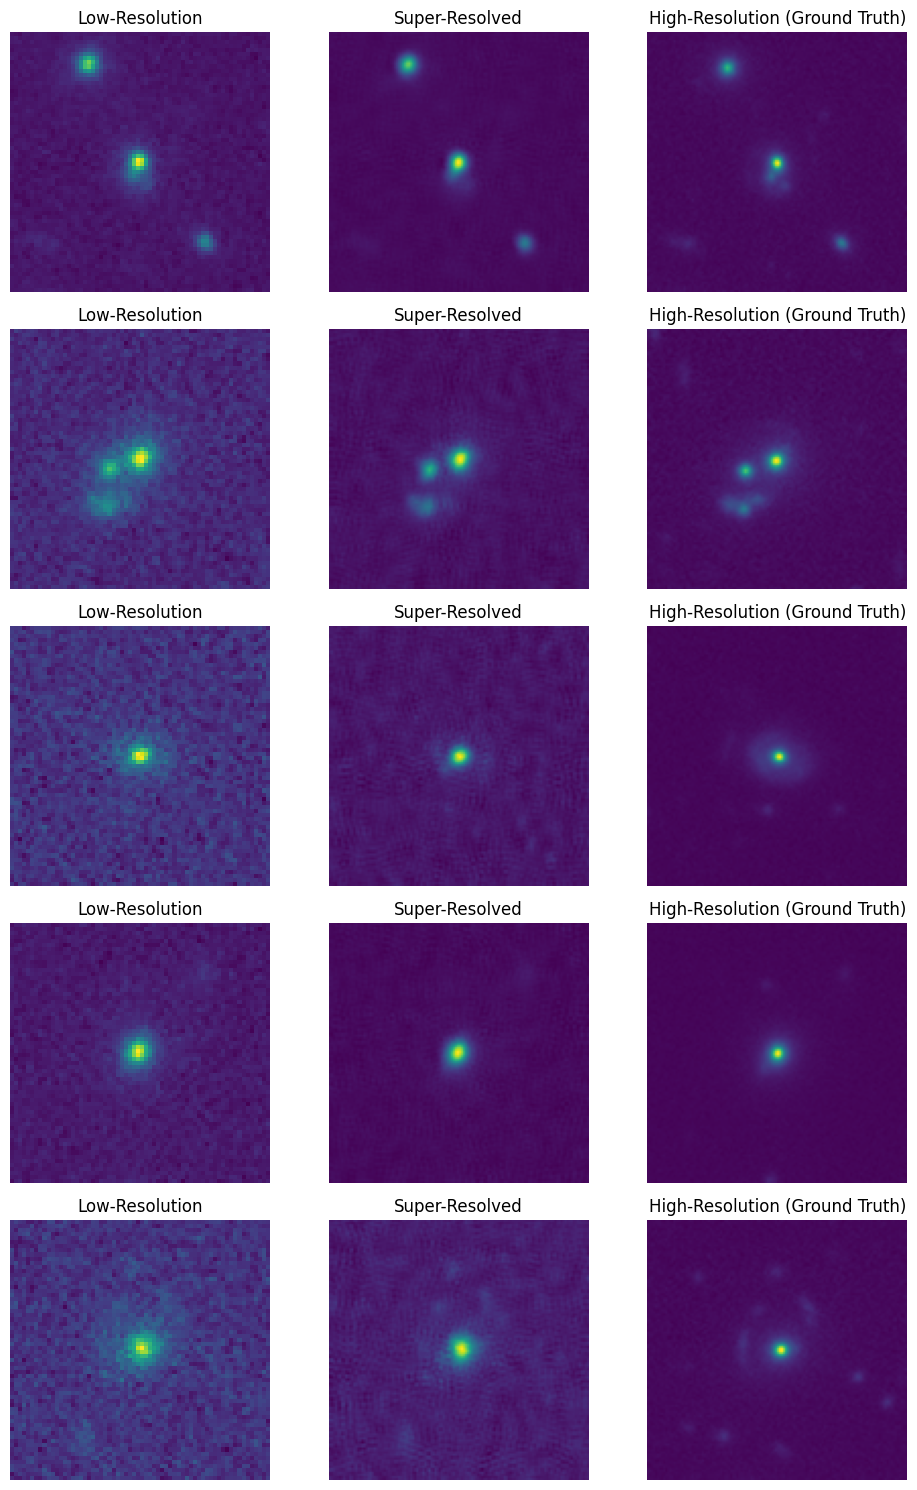

Final Evaluation - MSE: 0.000617117823518735, PSNR: 33.597832227559, SSIM: 0.8330429355303447


In [27]:
model = SRCNN(2, 32, [16], 9, [3], 5)
model = model.to(device)
model_save_path = "saved_models/best_sr_model_ft_2.pth"
model.load_state_dict(torch.load(model_save_path))
visualize_results(model, test_loader, num_samples=5, device=device)

model.eval()

# Evaluation loop
total_psnr, total_ssim, total_mse = 0.0, 0.0, 0.0
num_images = 0

with torch.no_grad():
    for lr_imgs, hr_imgs in test_loader:
        lr_imgs, hr_imgs = lr_imgs.to(device), hr_imgs.to(device)
        sr_imgs = model(lr_imgs)  # Generate SR images

        # Compute MSE, PSNR & SSIM for each image
        for i in range(lr_imgs.shape[0]):
            total_mse += mse(sr_imgs[i], hr_imgs[i])
            total_psnr += psnr(sr_imgs[i], hr_imgs[i], 255)
            total_ssim += ssim(sr_imgs[i].unsqueeze(0), hr_imgs[i].unsqueeze(0))
            num_images += 1

# Compute final average MSE, PSNR & SSIM
avg_mse = total_mse / num_images
avg_psnr = total_psnr / num_images
avg_ssim = total_ssim / num_images

print(f"Final Evaluation - MSE: {avg_mse}, PSNR: {avg_psnr}, SSIM: {avg_ssim}")

## ESPRCNN

In [ ]:
model = ESPCN(kernel_sizes=[9, 7, 5, 3], inp_channels=[1, 64, 32, 16], out_channels=[64, 32, 16, 16], scale_factor=2)
model = model.to(device)
model_load_path = "saved_models/espcn_model_1.pth" 
model.load_state_dict(torch.load(model_load_path))

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 50
patience = 10  # Stop training if no improvement for 5 consecutive epochs
best_val_loss = float('inf')
epochs_no_improve = 0
model_save_path = "saved_models/best_espcn_model_ft_1.pth"  # Path to save the best model

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    for lr_imgs, hr_imgs in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        lr_imgs, hr_imgs = lr_imgs.to(device), hr_imgs.to(device)

        sr_imgs = model(lr_imgs)

        loss = criterion(sr_imgs, hr_imgs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)

    # Validation step
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for lr_imgs, hr_imgs in test_loader:
            lr_imgs, hr_imgs = lr_imgs.to(device), hr_imgs.to(device)
            sr_imgs = model(lr_imgs)
            val_loss += criterion(sr_imgs, hr_imgs).item()

    avg_val_loss = val_loss / len(test_loader)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss}, Val Loss: {avg_val_loss}")

    # Early Stopping & Model Saving
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), model_save_path)  # Save best model
        print(f"✔ Model saved with Val Loss: {best_val_loss}")
    else:
        epochs_no_improve += 1
        print(f"❌ No improvement for {epochs_no_improve}/{patience} epochs.")

    if epochs_no_improve >= patience:
        print("⏹ Early stopping triggered!")
        break  # Stop training if no improvement for 'patience' epochs

print("✅ Training complete!")
print(f"📁 Best model saved at: {model_save_path}")

Epoch 1/50:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 1/50: 100%|██████████| 17/17 [00:00<00:00, 27.76it/s]


Epoch [1/50] - Train Loss: 0.0026800959569621176, Val Loss: 0.0010121639643330127
✔ Model saved with Val Loss: 0.0010121639643330127


Epoch 2/50: 100%|██████████| 17/17 [00:00<00:00, 27.95it/s]


Epoch [2/50] - Train Loss: 0.0016862335580620257, Val Loss: 0.0009115567663684487
✔ Model saved with Val Loss: 0.0009115567663684487


Epoch 3/50: 100%|██████████| 17/17 [00:00<00:00, 28.92it/s]


Epoch [3/50] - Train Loss: 0.0015429265091798322, Val Loss: 0.0007846603693906218
✔ Model saved with Val Loss: 0.0007846603693906218


Epoch 4/50: 100%|██████████| 17/17 [00:00<00:00, 29.60it/s]


Epoch [4/50] - Train Loss: 0.0014836650636211475, Val Loss: 0.000842361943796277
❌ No improvement for 1/10 epochs.


Epoch 5/50: 100%|██████████| 17/17 [00:00<00:00, 29.62it/s]


Epoch [5/50] - Train Loss: 0.0014749816481900565, Val Loss: 0.0007154075719881803
✔ Model saved with Val Loss: 0.0007154075719881803


Epoch 6/50: 100%|██████████| 17/17 [00:00<00:00, 29.45it/s]


Epoch [6/50] - Train Loss: 0.0014469490064691532, Val Loss: 0.0006733567424817011
✔ Model saved with Val Loss: 0.0006733567424817011


Epoch 7/50: 100%|██████████| 17/17 [00:00<00:00, 29.57it/s]


Epoch [7/50] - Train Loss: 0.0014152494841255248, Val Loss: 0.0006451664085034281
✔ Model saved with Val Loss: 0.0006451664085034281


Epoch 8/50: 100%|██████████| 17/17 [00:00<00:00, 29.66it/s]


Epoch [8/50] - Train Loss: 0.0014066786320387002, Val Loss: 0.000696743285516277
❌ No improvement for 1/10 epochs.


Epoch 9/50: 100%|██████████| 17/17 [00:00<00:00, 29.71it/s]


Epoch [9/50] - Train Loss: 0.0014072823550497346, Val Loss: 0.0006209506973391399
✔ Model saved with Val Loss: 0.0006209506973391399


Epoch 10/50: 100%|██████████| 17/17 [00:00<00:00, 29.64it/s]


Epoch [10/50] - Train Loss: 0.001394022548886235, Val Loss: 0.0006286701827775687
❌ No improvement for 1/10 epochs.


Epoch 11/50: 100%|██████████| 17/17 [00:00<00:00, 29.61it/s]


Epoch [11/50] - Train Loss: 0.0013822498525876332, Val Loss: 0.0006843366572866216
❌ No improvement for 2/10 epochs.


Epoch 12/50: 100%|██████████| 17/17 [00:00<00:00, 29.58it/s]


Epoch [12/50] - Train Loss: 0.00137923562022693, Val Loss: 0.000595713994698599
✔ Model saved with Val Loss: 0.000595713994698599


Epoch 13/50: 100%|██████████| 17/17 [00:00<00:00, 29.19it/s]


Epoch [13/50] - Train Loss: 0.0013508928104248993, Val Loss: 0.0006538928719237447
❌ No improvement for 1/10 epochs.


Epoch 14/50: 100%|██████████| 17/17 [00:00<00:00, 28.15it/s]


Epoch [14/50] - Train Loss: 0.0013434079831794782, Val Loss: 0.0006170306005515158
❌ No improvement for 2/10 epochs.


Epoch 15/50: 100%|██████████| 17/17 [00:00<00:00, 28.88it/s]


Epoch [15/50] - Train Loss: 0.001342499255449237, Val Loss: 0.0007903519435785711
❌ No improvement for 3/10 epochs.


Epoch 16/50: 100%|██████████| 17/17 [00:00<00:00, 29.32it/s]


Epoch [16/50] - Train Loss: 0.0013586669297450606, Val Loss: 0.000655740819638595
❌ No improvement for 4/10 epochs.


Epoch 17/50: 100%|██████████| 17/17 [00:00<00:00, 28.00it/s]


Epoch [17/50] - Train Loss: 0.0013662691892343847, Val Loss: 0.0006386832537828013
❌ No improvement for 5/10 epochs.


Epoch 18/50: 100%|██████████| 17/17 [00:00<00:00, 29.13it/s]


Epoch [18/50] - Train Loss: 0.00133386834332829, Val Loss: 0.0005871580651728436
✔ Model saved with Val Loss: 0.0005871580651728436


Epoch 19/50: 100%|██████████| 17/17 [00:00<00:00, 29.34it/s]


Epoch [19/50] - Train Loss: 0.0012975996154743958, Val Loss: 0.0006294835620792583
❌ No improvement for 1/10 epochs.


Epoch 20/50: 100%|██████████| 17/17 [00:00<00:00, 29.42it/s]


Epoch [20/50] - Train Loss: 0.001309453252949478, Val Loss: 0.0005734632431995124
✔ Model saved with Val Loss: 0.0005734632431995124


Epoch 21/50: 100%|██████████| 17/17 [00:00<00:00, 29.05it/s]


Epoch [21/50] - Train Loss: 0.0013300833764814718, Val Loss: 0.0005789169808849692
❌ No improvement for 1/10 epochs.


Epoch 22/50: 100%|██████████| 17/17 [00:00<00:00, 28.25it/s]


Epoch [22/50] - Train Loss: 0.0013050315833157476, Val Loss: 0.0007266264583449811
❌ No improvement for 2/10 epochs.


Epoch 23/50: 100%|██████████| 17/17 [00:00<00:00, 29.23it/s]


Epoch [23/50] - Train Loss: 0.001277884071254555, Val Loss: 0.0005627972859656438
✔ Model saved with Val Loss: 0.0005627972859656438


Epoch 24/50: 100%|██████████| 17/17 [00:00<00:00, 29.32it/s]


Epoch [24/50] - Train Loss: 0.0012676392284715, Val Loss: 0.0005603580502793193
✔ Model saved with Val Loss: 0.0005603580502793193


Epoch 25/50: 100%|██████████| 17/17 [00:00<00:00, 29.44it/s]


Epoch [25/50] - Train Loss: 0.0012776709473281004, Val Loss: 0.0005645245109917596
❌ No improvement for 1/10 epochs.


Epoch 26/50: 100%|██████████| 17/17 [00:00<00:00, 28.83it/s]


Epoch [26/50] - Train Loss: 0.0012497535687597359, Val Loss: 0.000583601780817844
❌ No improvement for 2/10 epochs.


Epoch 27/50: 100%|██████████| 17/17 [00:00<00:00, 28.58it/s]


Epoch [27/50] - Train Loss: 0.0012383953966063393, Val Loss: 0.0005647219368256629
❌ No improvement for 3/10 epochs.


Epoch 28/50: 100%|██████████| 17/17 [00:00<00:00, 29.07it/s]


Epoch [28/50] - Train Loss: 0.0012215720249942558, Val Loss: 0.0006179384072311223
❌ No improvement for 4/10 epochs.


Epoch 29/50: 100%|██████████| 17/17 [00:00<00:00, 29.23it/s]


Epoch [29/50] - Train Loss: 0.0012385443996583275, Val Loss: 0.0006039449945092201
❌ No improvement for 5/10 epochs.


Epoch 30/50: 100%|██████████| 17/17 [00:00<00:00, 29.20it/s]


Epoch [30/50] - Train Loss: 0.0012258783150601255, Val Loss: 0.0005755611055064946
❌ No improvement for 6/10 epochs.


Epoch 31/50: 100%|██████████| 17/17 [00:00<00:00, 29.10it/s]


Epoch [31/50] - Train Loss: 0.0012161744628375506, Val Loss: 0.0005428204749478027
✔ Model saved with Val Loss: 0.0005428204749478027


Epoch 32/50: 100%|██████████| 17/17 [00:00<00:00, 29.57it/s]


Epoch [32/50] - Train Loss: 0.0012172427001025748, Val Loss: 0.0005666767538059503
❌ No improvement for 1/10 epochs.


Epoch 33/50: 100%|██████████| 17/17 [00:00<00:00, 29.52it/s]


Epoch [33/50] - Train Loss: 0.0012065078070222894, Val Loss: 0.0005347523838281631
✔ Model saved with Val Loss: 0.0005347523838281631


Epoch 34/50: 100%|██████████| 17/17 [00:00<00:00, 29.59it/s]


Epoch [34/50] - Train Loss: 0.00121378230602097, Val Loss: 0.0006062526226742193
❌ No improvement for 1/10 epochs.


Epoch 35/50: 100%|██████████| 17/17 [00:00<00:00, 29.63it/s]


Epoch [35/50] - Train Loss: 0.001224025763804093, Val Loss: 0.0005446680006571114
❌ No improvement for 2/10 epochs.


Epoch 36/50: 100%|██████████| 17/17 [00:00<00:00, 28.19it/s]


Epoch [36/50] - Train Loss: 0.001285359968759996, Val Loss: 0.0005682682676706463
❌ No improvement for 3/10 epochs.


Epoch 37/50: 100%|██████████| 17/17 [00:00<00:00, 28.88it/s]


Epoch [37/50] - Train Loss: 0.0012105658448383432, Val Loss: 0.0005765771638834849
❌ No improvement for 4/10 epochs.


Epoch 38/50: 100%|██████████| 17/17 [00:00<00:00, 29.26it/s]


Epoch [38/50] - Train Loss: 0.0011995441112530364, Val Loss: 0.000545709699508734
❌ No improvement for 5/10 epochs.


Epoch 39/50: 100%|██████████| 17/17 [00:00<00:00, 29.43it/s]


Epoch [39/50] - Train Loss: 0.0012362304174423438, Val Loss: 0.0005874790658708662
❌ No improvement for 6/10 epochs.


Epoch 40/50: 100%|██████████| 17/17 [00:00<00:00, 28.86it/s]


Epoch [40/50] - Train Loss: 0.0011979458452996744, Val Loss: 0.0005379241629270837
❌ No improvement for 7/10 epochs.


Epoch 41/50: 100%|██████████| 17/17 [00:00<00:00, 29.13it/s]


Epoch [41/50] - Train Loss: 0.0011876560970182147, Val Loss: 0.0005300025950418785
✔ Model saved with Val Loss: 0.0005300025950418785


Epoch 42/50: 100%|██████████| 17/17 [00:00<00:00, 29.49it/s]


Epoch [42/50] - Train Loss: 0.0012454987839138245, Val Loss: 0.0005358259368222207
❌ No improvement for 1/10 epochs.


Epoch 43/50: 100%|██████████| 17/17 [00:00<00:00, 29.48it/s]


Epoch [43/50] - Train Loss: 0.0012422954742385842, Val Loss: 0.0005399000947363675
❌ No improvement for 2/10 epochs.


Epoch 44/50: 100%|██████████| 17/17 [00:00<00:00, 28.95it/s]


Epoch [44/50] - Train Loss: 0.0011984178341021214, Val Loss: 0.000616319477558136
❌ No improvement for 3/10 epochs.


Epoch 45/50: 100%|██████████| 17/17 [00:00<00:00, 29.44it/s]


Epoch [45/50] - Train Loss: 0.001185765303328962, Val Loss: 0.0005301828641677275
❌ No improvement for 4/10 epochs.


Epoch 46/50: 100%|██████████| 17/17 [00:00<00:00, 29.34it/s]


Epoch [46/50] - Train Loss: 0.0012079806748421535, Val Loss: 0.0005204344633966684
✔ Model saved with Val Loss: 0.0005204344633966684


Epoch 47/50: 100%|██████████| 17/17 [00:00<00:00, 29.60it/s]


Epoch [47/50] - Train Loss: 0.0012071485381217346, Val Loss: 0.0009086918435059488
❌ No improvement for 1/10 epochs.


Epoch 48/50: 100%|██████████| 17/17 [00:00<00:00, 28.01it/s]


Epoch [48/50] - Train Loss: 0.0012901387389694504, Val Loss: 0.0007511748699471354
❌ No improvement for 2/10 epochs.


Epoch 49/50: 100%|██████████| 17/17 [00:00<00:00, 29.31it/s]


Epoch [49/50] - Train Loss: 0.0012267247468972689, Val Loss: 0.0005325705569703132
❌ No improvement for 3/10 epochs.


Epoch 50/50: 100%|██████████| 17/17 [00:00<00:00, 28.96it/s]

Epoch [50/50] - Train Loss: 0.001183427937041201, Val Loss: 0.0006208281265571713
❌ No improvement for 4/10 epochs.
✅ Training complete!
📁 Best model saved at: saved_models/best_espcn_model_ft_1.pth


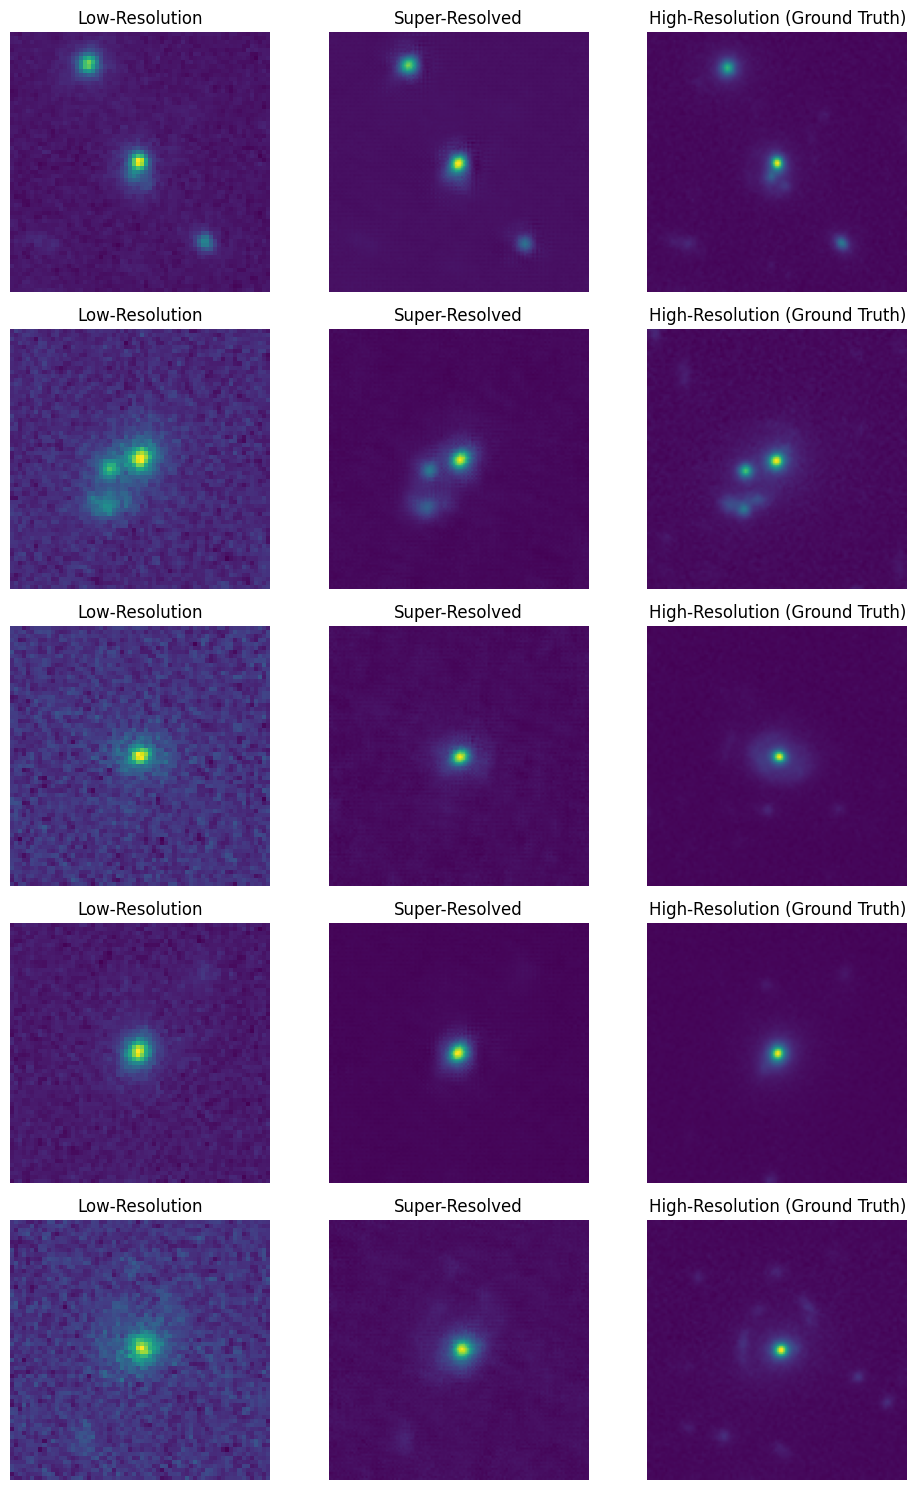

Final Evaluation - MSE: 0.0005324304453097284, PSNR: 34.2208255072552, SSIM: 0.8552969674269358


In [31]:
model = ESPCN(kernel_sizes=[9, 7, 5, 3], inp_channels=[1, 64, 32, 16], out_channels=[64, 32, 16, 16], scale_factor=2)
model = model.to(device)
model_save_path = "saved_models/best_espcn_model_ft_1.pth"
model.load_state_dict(torch.load(model_save_path))
visualize_results(model, test_loader, num_samples=5, device=device)

model.eval()

# Evaluation loop
total_psnr, total_ssim, total_mse = 0.0, 0.0, 0.0
num_images = 0

with torch.no_grad():
    for lr_imgs, hr_imgs in test_loader:
        lr_imgs, hr_imgs = lr_imgs.to(device), hr_imgs.to(device)
        sr_imgs = model(lr_imgs)  # Generate SR images

        # Compute MSE, PSNR & SSIM for each image
        for i in range(lr_imgs.shape[0]):
            total_mse += mse(sr_imgs[i], hr_imgs[i])
            total_psnr += psnr(sr_imgs[i], hr_imgs[i], 255)
            total_ssim += ssim(sr_imgs[i].unsqueeze(0), hr_imgs[i].unsqueeze(0))
            num_images += 1

# Compute final average MSE, PSNR & SSIM
avg_mse = total_mse / num_images
avg_psnr = total_psnr / num_images
avg_ssim = total_ssim / num_images

print(f"Final Evaluation - MSE: {avg_mse}, PSNR: {avg_psnr}, SSIM: {avg_ssim}")

## SRResNet

In [34]:
model = SRGenerator(1, 64, (3, 3), (9, 9), 4, upscale_factor=2).to(device)
model = model.to(device)
model_load_path = "saved_models/srresnet_model_1.pth"
model.load_state_dict(torch.load(model_load_path))

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 50
patience = 10  # Stop training if no improvement for 5 consecutive epochs
best_val_loss = float('inf')
epochs_no_improve = 0
model_save_path = "saved_models/best_srresnet_model_ft_1.pth"  # Path to save the best model

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    for lr_imgs, hr_imgs in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        lr_imgs, hr_imgs = lr_imgs.to(device), hr_imgs.to(device)

        sr_imgs = model(lr_imgs)

        loss = criterion(sr_imgs, hr_imgs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)

    # Validation step
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for lr_imgs, hr_imgs in test_loader:
            lr_imgs, hr_imgs = lr_imgs.to(device), hr_imgs.to(device)
            sr_imgs = model(lr_imgs)
            val_loss += criterion(sr_imgs, hr_imgs).item()

    avg_val_loss = val_loss / len(test_loader)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss}, Val Loss: {avg_val_loss}")

    # Early Stopping & Model Saving
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), model_save_path)  # Save best model
        print(f"✔ Model saved with Val Loss: {best_val_loss}")
    else:
        epochs_no_improve += 1
        print(f"❌ No improvement for {epochs_no_improve}/{patience} epochs.")

    if epochs_no_improve >= patience:
        print("⏹ Early stopping triggered!")
        break  # Stop training if no improvement for 'patience' epochs

print("✅ Training complete!")
print(f"📁 Best model saved at: {model_save_path}")

Epoch 1/50: 100%|██████████| 17/17 [00:06<00:00,  2.52it/s]


Epoch [1/50] - Train Loss: 0.00216289862360367, Val Loss: 0.0010932388249784708
✔ Model saved with Val Loss: 0.0010932388249784708


Epoch 2/50: 100%|██████████| 17/17 [00:06<00:00,  2.55it/s]


Epoch [2/50] - Train Loss: 0.0013942003099466948, Val Loss: 0.0007157714571803808
✔ Model saved with Val Loss: 0.0007157714571803808


Epoch 3/50: 100%|██████████| 17/17 [00:06<00:00,  2.55it/s]


Epoch [3/50] - Train Loss: 0.0013591692789786441, Val Loss: 0.0010560233786236495
❌ No improvement for 1/10 epochs.


Epoch 4/50: 100%|██████████| 17/17 [00:06<00:00,  2.54it/s]


Epoch [4/50] - Train Loss: 0.0015155305154621601, Val Loss: 0.0006655926117673516
✔ Model saved with Val Loss: 0.0006655926117673516


Epoch 5/50: 100%|██████████| 17/17 [00:06<00:00,  2.54it/s]


Epoch [5/50] - Train Loss: 0.001349745729171178, Val Loss: 0.0005998776468914002
✔ Model saved with Val Loss: 0.0005998776468914002


Epoch 6/50: 100%|██████████| 17/17 [00:06<00:00,  2.54it/s]


Epoch [6/50] - Train Loss: 0.0013031564868630514, Val Loss: 0.000813380436738953
❌ No improvement for 1/10 epochs.


Epoch 7/50: 100%|██████████| 17/17 [00:06<00:00,  2.54it/s]


Epoch [7/50] - Train Loss: 0.0012756063575472903, Val Loss: 0.0005814100004499778
✔ Model saved with Val Loss: 0.0005814100004499778


Epoch 8/50: 100%|██████████| 17/17 [00:06<00:00,  2.54it/s]


Epoch [8/50] - Train Loss: 0.0012816834530573996, Val Loss: 0.0006485423073172569
❌ No improvement for 1/10 epochs.


Epoch 9/50: 100%|██████████| 17/17 [00:06<00:00,  2.54it/s]


Epoch [9/50] - Train Loss: 0.0013144594986977823, Val Loss: 0.000532624006154947
✔ Model saved with Val Loss: 0.000532624006154947


Epoch 10/50: 100%|██████████| 17/17 [00:06<00:00,  2.54it/s]


Epoch [10/50] - Train Loss: 0.0012787073227467343, Val Loss: 0.0006183013611007482
❌ No improvement for 1/10 epochs.


Epoch 11/50: 100%|██████████| 17/17 [00:06<00:00,  2.54it/s]


Epoch [11/50] - Train Loss: 0.0012782591579975013, Val Loss: 0.0006497617578133941
❌ No improvement for 2/10 epochs.


Epoch 12/50: 100%|██████████| 17/17 [00:06<00:00,  2.54it/s]


Epoch [12/50] - Train Loss: 0.0012394756366334418, Val Loss: 0.0007077814370859414
❌ No improvement for 3/10 epochs.


Epoch 13/50: 100%|██████████| 17/17 [00:06<00:00,  2.54it/s]


Epoch [13/50] - Train Loss: 0.0012629495895988144, Val Loss: 0.0011898463126271963
❌ No improvement for 4/10 epochs.


Epoch 14/50: 100%|██████████| 17/17 [00:06<00:00,  2.54it/s]


Epoch [14/50] - Train Loss: 0.001260505648507901, Val Loss: 0.0007165999559219927
❌ No improvement for 5/10 epochs.


Epoch 15/50: 100%|██████████| 17/17 [00:06<00:00,  2.54it/s]


Epoch [15/50] - Train Loss: 0.0012366359433679678, Val Loss: 0.0004909200506517664
✔ Model saved with Val Loss: 0.0004909200506517664


Epoch 16/50: 100%|██████████| 17/17 [00:06<00:00,  2.54it/s]


Epoch [16/50] - Train Loss: 0.0012403714028871892, Val Loss: 0.005195650737732649
❌ No improvement for 1/10 epochs.


Epoch 17/50: 100%|██████████| 17/17 [00:06<00:00,  2.53it/s]


Epoch [17/50] - Train Loss: 0.0012746623919263262, Val Loss: 0.0005191659729462117
❌ No improvement for 2/10 epochs.


Epoch 18/50: 100%|██████████| 17/17 [00:06<00:00,  2.53it/s]


Epoch [18/50] - Train Loss: 0.0012693064670790644, Val Loss: 0.0005627029167953879
❌ No improvement for 3/10 epochs.


Epoch 19/50: 100%|██████████| 17/17 [00:06<00:00,  2.53it/s]


Epoch [19/50] - Train Loss: 0.0012546442586052068, Val Loss: 0.0022325682220980525
❌ No improvement for 4/10 epochs.


Epoch 20/50: 100%|██████████| 17/17 [00:06<00:00,  2.53it/s]


Epoch [20/50] - Train Loss: 0.0012780698529882904, Val Loss: 0.005206867353990674
❌ No improvement for 5/10 epochs.


Epoch 21/50: 100%|██████████| 17/17 [00:06<00:00,  2.53it/s]


Epoch [21/50] - Train Loss: 0.0012801940337179556, Val Loss: 0.0006891881639603525
❌ No improvement for 6/10 epochs.


Epoch 22/50: 100%|██████████| 17/17 [00:06<00:00,  2.52it/s]


Epoch [22/50] - Train Loss: 0.0012956157597192727, Val Loss: 0.002902769250795245
❌ No improvement for 7/10 epochs.


Epoch 23/50: 100%|██████████| 17/17 [00:06<00:00,  2.53it/s]


Epoch [23/50] - Train Loss: 0.0012402274707496604, Val Loss: 0.0005045778671046719
❌ No improvement for 8/10 epochs.


Epoch 24/50: 100%|██████████| 17/17 [00:06<00:00,  2.53it/s]


Epoch [24/50] - Train Loss: 0.001178555514129317, Val Loss: 0.0006649170245509595
❌ No improvement for 9/10 epochs.


Epoch 25/50: 100%|██████████| 17/17 [00:06<00:00,  2.53it/s]

Epoch [25/50] - Train Loss: 0.0011687106778160395, Val Loss: 0.0004991160676581785
❌ No improvement for 10/10 epochs.
⏹ Early stopping triggered!
✅ Training complete!
📁 Best model saved at: saved_models/best_srresnet_model_ft_1.pth


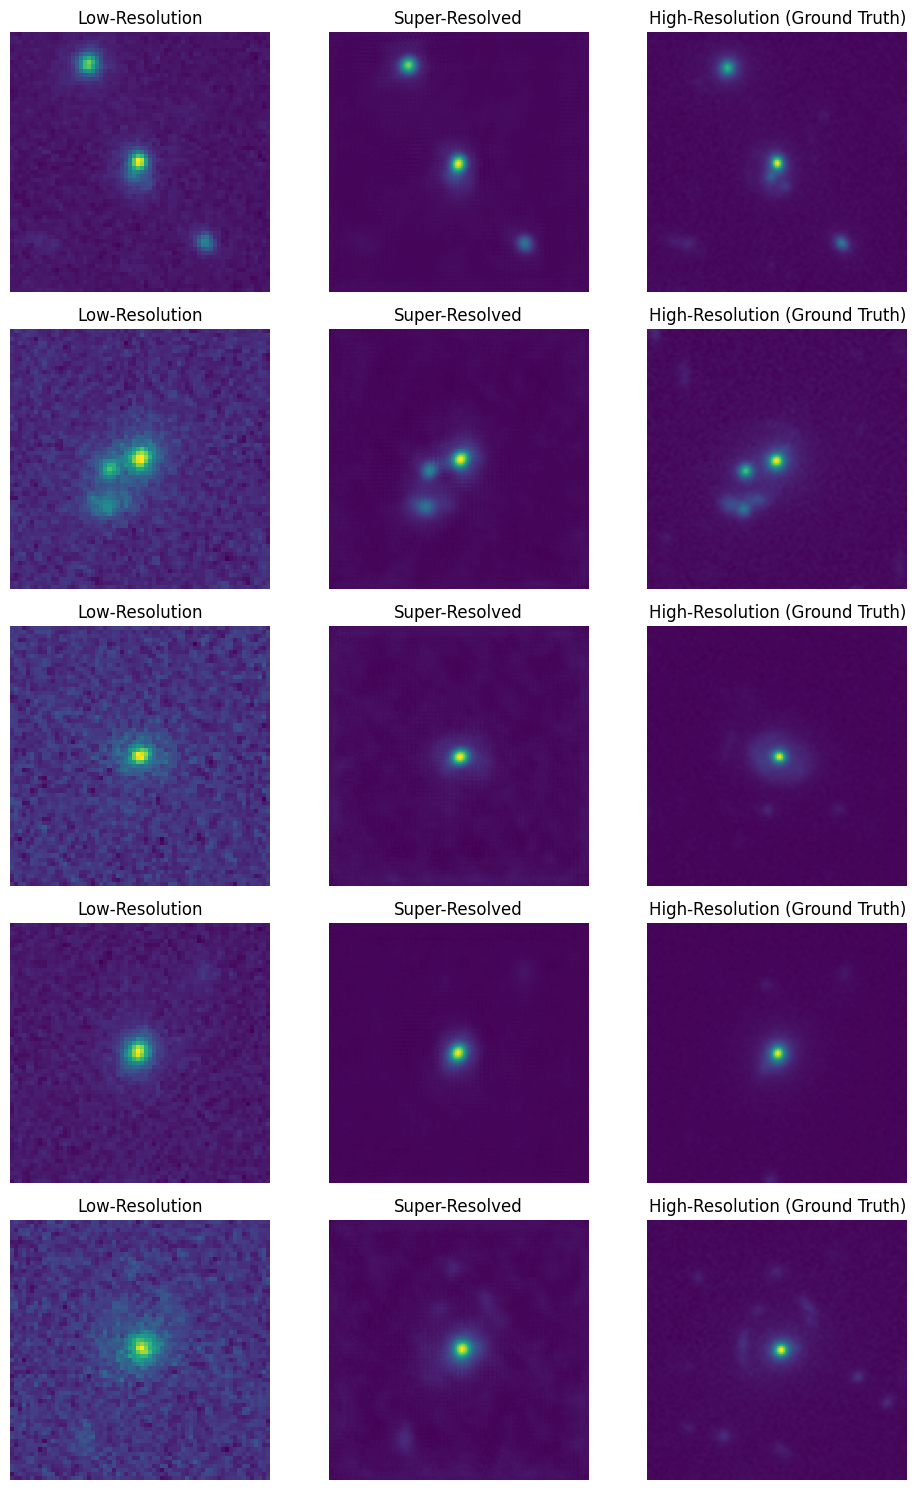

Final Evaluation - MSE: 0.0004997482639737428, PSNR: 34.67005936788362, SSIM: 0.8611923972765605


In [35]:
model = SRGenerator(1, 64, (3, 3), (9, 9), 4, upscale_factor=2).to(device)
model = model.to(device)
model_save_path = "saved_models/best_srresnet_model_ft_1.pth"
model.load_state_dict(torch.load(model_save_path))
visualize_results(model, test_loader, num_samples=5, device=device)

model.eval()

# Evaluation loop
total_psnr, total_ssim, total_mse = 0.0, 0.0, 0.0
num_images = 0

with torch.no_grad():
    for lr_imgs, hr_imgs in test_loader:
        lr_imgs, hr_imgs = lr_imgs.to(device), hr_imgs.to(device)
        sr_imgs = model(lr_imgs)  # Generate SR images

        # Compute MSE, PSNR & SSIM for each image
        for i in range(lr_imgs.shape[0]):
            total_mse += mse(sr_imgs[i], hr_imgs[i])
            total_psnr += psnr(sr_imgs[i], hr_imgs[i], 255)
            total_ssim += ssim(sr_imgs[i].unsqueeze(0), hr_imgs[i].unsqueeze(0))
            num_images += 1

# Compute final average MSE, PSNR & SSIM
avg_mse = total_mse / num_images
avg_psnr = total_psnr / num_images
avg_ssim = total_ssim / num_images

print(f"Final Evaluation - MSE: {avg_mse}, PSNR: {avg_psnr}, SSIM: {avg_ssim}")